# Libraries

In [1]:
import glob
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import os.path as osp
import glob

from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os

import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import shuffle

import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
!pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [3]:
DEVICE = 'cuda'
EPOCHS=20
LR = 0.003
BATCH_SIZE = 16
IMG_SIZE = 256

# Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Final_Project/circularMask.zip" -d "/content/dataset"
!unzip "/content/drive/MyDrive/Final_Project/image.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/image/05118.png  
  inflating: /content/dataset/image/05149.png  
  inflating: /content/dataset/image/05196.png  
  inflating: /content/dataset/image/05214.png  
  inflating: /content/dataset/image/05230.png  
  inflating: /content/dataset/image/05236.png  
  inflating: /content/dataset/image/05237.png  
  inflating: /content/dataset/image/05244.png  
  inflating: /content/dataset/image/05263.png  
  inflating: /content/dataset/image/05292.png  
  inflating: /content/dataset/image/05302.png  
  inflating: /content/dataset/image/05322.png  
  inflating: /content/dataset/image/05335.png  
  inflating: /content/dataset/image/05344.png  
  inflating: /content/dataset/image/05369.png  
  inflating: /content/dataset/image/05374.png  
  inflating: /content/dataset/image/05386.png  
  inflating: /content/dataset/image/05410.png  
  inflating: /content/dataset/image/05422.png  
  inflating: /content/dataset/image/0

In [ ]:
mask_dir = '/home/bcca/Desktop/Akshit/dataset/circularMask'
image_dir = '/home/bcca/Desktop/Akshit/dataset/image'

# List the files in each directory
mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')]
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

# Sort files to maintain order, if necessary
mask_files.sort()
image_files.sort()

# Create the DataFrame
df = pd.DataFrame({
    'masks': mask_files,
    'images': image_files
})


In [ ]:
df.head()

,masks,images
0,/home/bcca/Desktop/Akshit/dataset/circularMask...,/home/bcca/Desktop/Akshit/dataset/image/00001.png
1,/home/bcca/Desktop/Akshit/dataset/circularMask...,/home/bcca/Desktop/Akshit/dataset/image/00002.png
2,/home/bcca/Desktop/Akshit/dataset/circularMask...,/home/bcca/Desktop/Akshit/dataset/image/00003.png
3,/home/bcca/Desktop/Akshit/dataset/circularMask...,/home/bcca/Desktop/Akshit/dataset/image/00004.png
4,/home/bcca/Desktop/Akshit/dataset/circularMask...,/home/bcca/Desktop/Akshit/dataset/image/00005.png


In [ ]:
row = df.iloc[1]
image_path=row.images
mask_path = row.masks
image  = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

In [ ]:
mask.shape

(256, 256)

In [ ]:
image.shape

torch.Size([3, 256, 256])

In [ ]:
train_df,valid_df= train_test_split(df,test_size = 0.2,random_state = 42)

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Load the Dataset into Dataloader

In [ ]:
# def load_image_paths(base_path, label_path, image_path, sample_size=5000):
#     label_dir = os.path.join(base_path, label_path)
#     image_dir = os.path.join(base_path, image_path)

#     label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')]
#     image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

#     # Ensure matching pairs are selected
#     label_files.sort()
#     image_files.sort()

#     # Shuffle with the same seed to maintain pairing
#     label_files, image_files = shuffle(label_files, image_files, random_state=42)

#     # Select a subset
#     label_files_subset = label_files[:sample_size]
#     image_files_subset = image_files[:sample_size]

#     return label_files_subset, image_files_subset

# # Assuming "/content/dataset" is your base path and it contains "labels" and "images" folders
# label_files, image_files = load_image_paths("/content/dataset", "circularMask", "image", 1500)


In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentation):
    self.df = df
    self.augmentation = augmentation
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    image_path=row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #SHAPE OF (h,w,c)
    mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
    mask = np.expand_dims(mask , axis = -1)

    if self.augmentation:
      data = self.augmentation(image = image ,mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c)--->(c,h,w) pytorch format
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask))/255.0
    return image , mask

In [ ]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE ,shuffle =True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE,shuffle = True)

In [ ]:
# # noise=folder_data
# # clean=folder_mask

# noise=image_files
# clean= label_files

In [ ]:
# # split these path using a certain percentage
# len_data = len(noise)

# train_size = 0.8
# #--------------------------------   Nosie Image Path --------------------------------------------------------------------------
# train_noise_paths = noise[:int(len_data*train_size)]
# test_noise_paths = noise[int(len_data*train_size):]

# #--------------------------------  Clean Image Path  --------------------------------------------------------------------------
# train_clean_paths = clean[:int(len_data*train_size)]
# test_clean_paths = clean[int(len_data*train_size):]



# class CustomDataset(Dataset):
#     def __init__(self, image_paths, target_paths, train=True):# initial logic happens like transform
#         self.image_paths = image_paths
#         self.target_paths = target_paths
#         self.transforms = transforms.ToTensor()

#     def __getitem__(self, index):

#         image = Image.open(self.image_paths[index])
#         clean = Image.open(self.target_paths[index])
#         t_image = self.transforms(image)
#         t_clean = self.transforms(clean)
#         return t_image, t_clean

#     def __len__(self):  # return count of sample we have
#         return len(self.image_paths)

# train_dataset = CustomDataset(train_noise_paths, train_clean_paths, train=True)
# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

# test_dataset = CustomDataset(test_noise_paths, test_clean_paths, train=False)
# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# train_noise_paths

NameError: name 'train_noise_paths' is not defined

In [ ]:
# print(len(test_dataset))
# print(len(train_dataset))

300
1200


In [ ]:
noisy_imgs, clean_imgs = next(iter(trainloader))

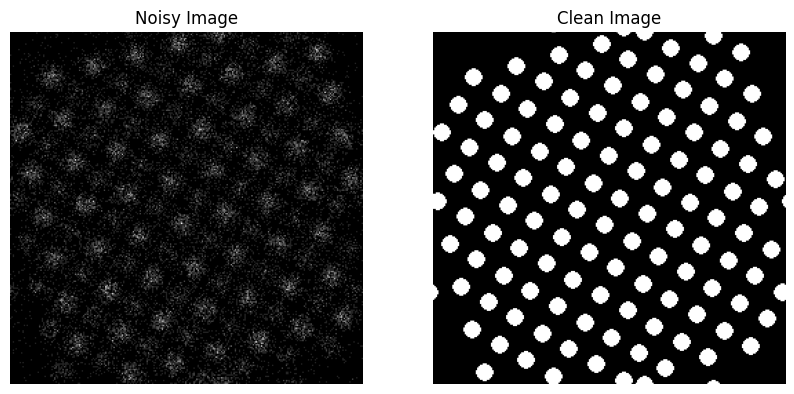

In [ ]:
noisy_img_np = noisy_imgs[0].numpy().transpose(1, 2, 0)
clean_img_np = clean_imgs[0].numpy().transpose(1, 2, 0)

# Plotting the noisy and clean images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the noisy image
axs[0].imshow(noisy_img_np, cmap='gray')
axs[0].set_title('Noisy Image')
axs[0].axis('off')

# Plot the clean image
axs[1].imshow(clean_img_np, cmap='gray')
axs[1].set_title('Clean Image')
axs[1].axis('off')

plt.show()

In [ ]:
print("total no. of batches in trainloader",len(trainloader))
print("total no. of batches in validloader",len(validloader))

total no. of batches in trainloader 719
total no. of batches in validloader 180


In [ ]:
for image,mask in(trainloader):
  break
print("One batch image shape",(image.shape))
print("One batch mask shape",(mask.shape))

One batch image shape torch.Size([16, 3, 256, 256])
One batch mask shape torch.Size([16, 1, 256, 256])


# Model

In [5]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [6]:
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes = 1,
        activation = None

    )

  def forward(self,images,masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode= 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1 +loss2
    return logits

In [7]:
model =   SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 190MB/s]


In [8]:
model

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Loss Function

In [ ]:
def calculate_iou(pred_mask, true_mask):
    pred_mask = pred_mask.detach().cpu().squeeze(0).numpy()  # Move to CPU and convert to NumPy array
    true_mask = true_mask.detach().cpu().squeeze(0).numpy()  # Move to CPU and convert to NumPy array

    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()

    iou = intersection / union if union > 0 else 0.0  # Avoid division by zero
    return iou


# Train Function

In [ ]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Calculate IoU for each batch
        for i in range(len(images)):
            total_iou += calculate_iou(preds[i], masks[i].squeeze())

        # Calculate loss
        logits,loss = model(images,masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += images.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / total_samples
    return avg_loss, avg_iou


In [ ]:
loss_train=[]
loss_valid=[]
train_iou=[]
valid_iou=[]
iteration=[]

# Training Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss,iou_train = train_fn(trainloader,model,optimizer)
  # valid_loss,iou_valid = eval_fn(validloader,model)
  loss_train.append(train_loss)
  # loss_valid.append(valid_loss)
  train_iou.append(iou_train)
  # valid_iou.append(iou_valid)
  iteration.append(i+1)


  # if valid_loss <best_valid_loss:
  #   torch.save(model.state_dict(),'best_model.pt')
  #   print("saved model")
  #   best_valid_loss = valid_loss



  # print(f"Epoch :{i+1} Train Loss:{train_loss}  Valid_Loss: {valid_loss} Iou_train: {iou_train} Iou_valid: {iou_valid}")


100%|██████████| 719/719 [02:04<00:00,  5.78it/s]


In [ ]:
torch.save(model.state_dict(),'best_model.pt')

In [ ]:
idx = 23

#here we are going to use valid set as test set
model.load_state_dict(torch.load('/content/drive/MyDrive/Final_Project/best_model.pt'))
image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

In [ ]:
image.shape

torch.Size([3, 256, 256])

In [ ]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')



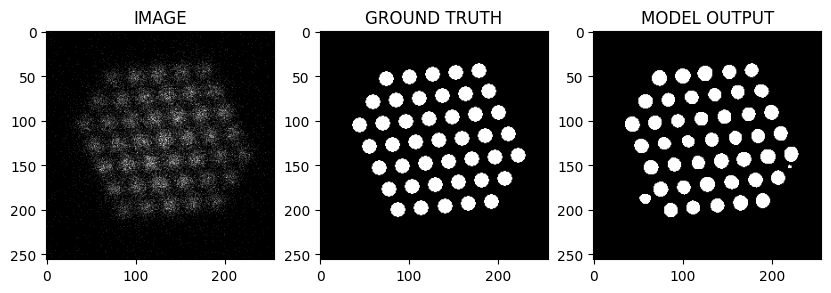

In [ ]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# Custom Dataset Testing

In [9]:
import torch
from torchvision import transforms
import numpy as np


In [67]:
img_path='/content/drive/MyDrive/Final_Project/test.png'
img=cv2.imread(img_path)

In [87]:
img_path='/content/drive/MyDrive/Final_Project/test0.jpg'
img=cv2.imread(img_path)

In [32]:
image_path = '/content/drive/MyDrive/Final_Project/full_TEM_image_1.jpg'
img=cv2.imread(image_path)

In [88]:
img.shape

(138, 153, 3)

In [81]:
from PIL import Image
import numpy as np

# Load the image
image = Image.open(image_path)

# Resize using PIL's ANTIALIAS interpolation
img = image.resize((256, 256), Image.ANTIALIAS)

# Convert the resized image back to a numpy array
img = np.array(img)


<ipython-input-81-42fb534ddd7c>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = image.resize((256, 256), Image.ANTIALIAS)


In [98]:
original_image = Image.open(image_path)

# Get the dimensions of the original image
width, height = original_image.size

# Calculate the dimensions for each part
part_width = width // 4
part_height = height // 4

# Define the regions for each part
regions = [
    (0, 0, part_width, part_height),  # Top-left part
    (part_width, 0, 2*part_width, part_height),  # Top-middle part
    (2*part_width, 0, 3*part_width, part_height),  # Top-right part
    (3*part_width, 0, width, part_height),  # Top-far-right part
    (0, part_height, part_width, 2*part_height),  # Middle-left part
    (part_width, part_height, 2*part_width, 2*part_height),  # Center part
    (2*part_width, part_height, 3*part_width, 2*part_height),  # Middle-right part
    (3*part_width, part_height, width, 2*part_height),  # Far-right part
    (0, 2*part_height, part_width, height),  # Bottom-left part
    (part_width, 2*part_height, 2*part_width, height),  # Bottom-middle part
    (2*part_width, 2*part_height, 3*part_width, height),  # Bottom-right part
    (3*part_width, 2*part_height, width, height)  # Bottom-far-right part
]

# Initialize an empty list to store the parts
part_images = []

# Crop each part and store it in the list
for region in regions:
    part = original_image.crop(region)
    part_images.append(part)



In [102]:
img=part_images[3]

In [103]:
img = np.array(img)

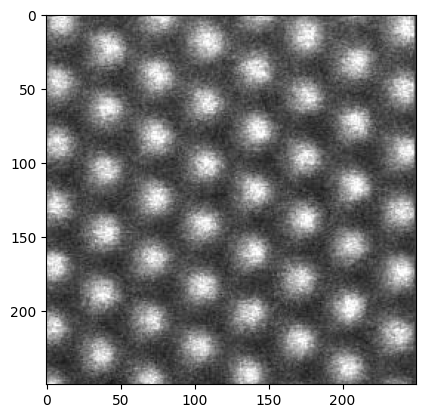

In [104]:
plt.imshow(img)


In [105]:

# Assuming img is your NumPy image array of shape (786, 786, 3)

# First, convert your NumPy array to a PyTorch tensor
img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()  # This converts it to (3, 786, 786) and changes type to float

# Now, define a resize transform
resize_transform = transforms.Resize((256, 256))

# Apply the transform
img_resized = resize_transform(img_tensor)

# Check the size, it should be torch.Size([3, 256, 256])
print(img_resized.size())


torch.Size([3, 256, 256])


In [35]:
from scipy.ndimage import gaussian_filter

In [106]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Final_Project/best_model.pt'))
logits_mask = model(img_resized.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

In [111]:
pred_image=pred_mask.detach().cpu()
gaussian_image= pred_image.reshape(256, 256, 1)
gaussian_image= gaussian_filter(gaussian_image, sigma=5)

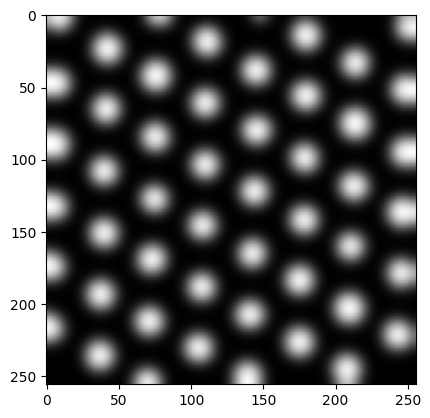

In [112]:
plt.imshow(gaussian_image, cmap='gray')

In [61]:
def test_show(image,gaussian_image, pred_image = None):



        f, (ax1, ax2, ax3 ) = plt.subplots(1, 3, figsize=(10,5))
        image = image.permute(1, 2, 0).numpy()
        ax1.set_title('Test Image')
        ax1.imshow(image.astype('uint8'),cmap = 'gray')

        ax2.set_title('Simulated Gaussian TEM Image')
        ax2.imshow(gaussian_image,cmap = 'gray')

        ax3.set_title('Segmentation')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')




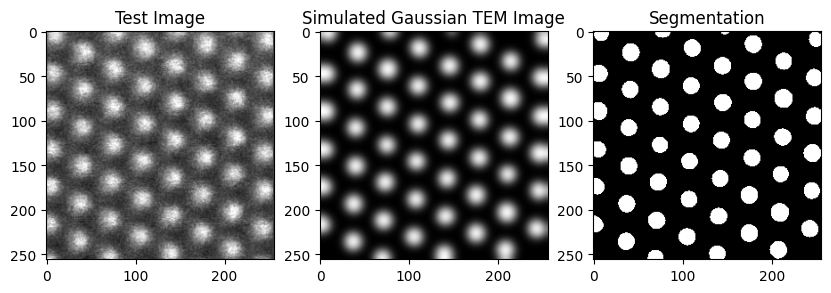

In [113]:
test_show(img_resized,gaussian_image,pred_mask.detach().cpu().squeeze(0))